## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

if not os.path.exists("jet.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/jet.bmp --no-check-certificate



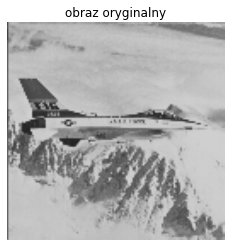

In [2]:
I = cv2.imread("jet.bmp")
# I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

hist = cv2.calcHist([I], [0], None, [256], [0,256])

plt.imshow(I)
plt.axis('off')
plt.title("obraz oryginalny")
plt.show()

### BBHE

In [3]:
lm = np.average(I)
lm

169.29061889648438

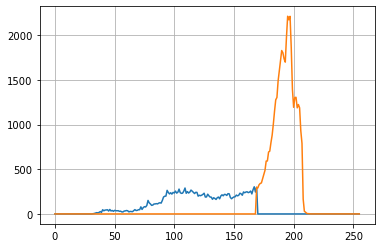

In [4]:
mask1 = cv2.inRange(I, np.array((0., 0., 0.)), np.array((lm, lm, lm)))
mask2 = cv2.inRange(I, np.array((lm, lm, lm)), np.array((256., 256., 256.)))

H1 = cv2.calcHist([I], [0], mask1, [256], [0,256])
H2 = cv2.calcHist([I], [0], mask2, [256], [0,256])

plt.plot(H1)
plt.plot(H2)
plt.grid()
plt.show()

In [5]:
C1 = cv2.normalize(H1, None, 0, lm, cv2.NORM_MINMAX)
C2 = cv2.normalize(H2, None, lm, 255, cv2.NORM_MINMAX)

# plt.plot(C1)
# plt.plot(C2)
# plt.plot(C1+C2)
# plt.grid()
# plt.show()

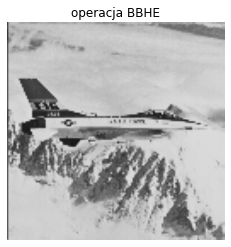

In [6]:
hist = C1 + C2
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
BBHE = cdf[I]

plt.imshow(BBHE, 'gray')
plt.axis('off')
plt.title('operacja BBHE')
plt.show()

### DSIHE

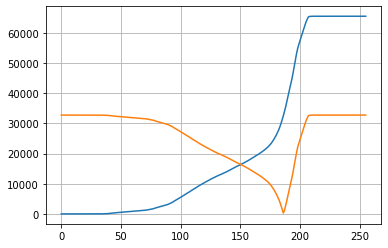

186

In [7]:
HHist = cv2.calcHist([I], [0], None, [256], [0,256])
CHistNorm = np.cumsum(HHist)
modCHistNorm = np.abs((CHistNorm)-np.max(CHistNorm)/2)

plt.plot(CHistNorm)
plt.plot(modCHistNorm)
plt.grid()
plt.show()

lm = np.argwhere(modCHistNorm == np.min(modCHistNorm))[0][0]
lm

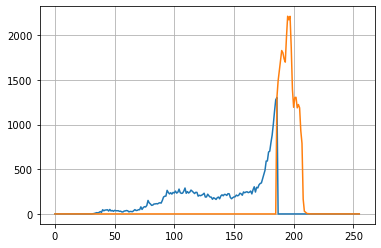

In [8]:
mask1 = cv2.inRange(I, np.array((0., 0., 0.)), np.array((lm, lm, lm), dtype=np.double))
mask2 = cv2.inRange(I, np.array((lm, lm, lm), dtype=np.double), np.array((256., 256., 256.)))

H1 = cv2.calcHist([I], [0], mask1, [256], [0,256])
H2 = cv2.calcHist([I], [0], mask2, [256], [0,256])

plt.plot(H1)
plt.plot(H2)
plt.grid()
plt.show()

In [9]:
C1 = cv2.normalize(H1, None, 0, lm, cv2.NORM_MINMAX)
C2 = cv2.normalize(H2, None, lm, 255, cv2.NORM_MINMAX)

# plt.plot(C1)
# plt.plot(C2)
# plt.plot(C1+C2)
# plt.grid()
# plt.show()

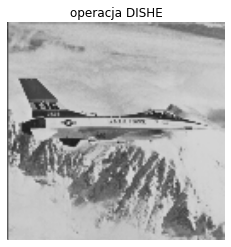

In [10]:
hist = C1 + C2
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
DISHE = cdf[I]

plt.imshow(DISHE, 'gray')
plt.axis('off')
plt.title('operacja DISHE')
plt.show()

### Porównanie

In [11]:
Ia = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
HE = cv2.equalizeHist(Ia)

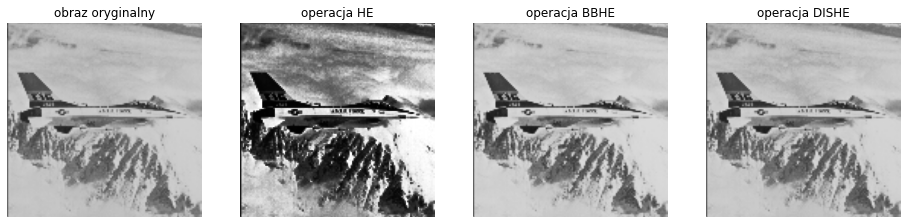

In [12]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(16, 4)
ax[0].imshow(I)
ax[0].set_title("obraz oryginalny")
ax[1].imshow(HE, 'gray')
ax[1].set_title("operacja HE")
ax[2].imshow(BBHE, 'gray')
ax[2].set_title("operacja BBHE")
ax[3].imshow(DISHE, 'gray')
ax[3].set_title("operacja DISHE")

for i in range(4):
    ax[i].axis('off')
plt.show()